In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters Vector

Load and normalization vector of parameters.

In [2]:
# Loading each csv file
allpatients = pd.read_csv('Time_Female.csv')
allpatients.head()

,MAX,MIN,RMS,KURTOSIS,SKEWNESS,Status
0,18760.0,-11958.0,5294.547930,0.317484,0.894478,Chory
1,7822.0,-9809.0,3423.929549,-0.643199,-0.277961,Chory
2,8645.0,-12309.0,3791.464376,-0.876762,-0.070322,Chory
3,7948.0,-13705.0,3430.957024,-0.716686,-0.419052,Chory
4,19539.0,-17650.0,4096.550818,0.617535,0.500717,Chory


Features has diffrent rows, so they have to be normalized.

In [3]:
features = allpatients.drop(labels='Status', axis=1).columns
for i in features:
    allpatients[i] = (allpatients[i] - np.mean(allpatients[i]))/np.std(allpatients[i])
allpatients.head()

,MAX,MIN,RMS,KURTOSIS,SKEWNESS,Status
0,0.392833,0.650963,-0.147024,0.270322,1.307170,Chory
1,-1.637035,0.990899,-1.229182,-0.782410,-1.406034,Chory
2,-1.484303,0.595441,-1.016562,-1.038352,-0.925525,Chory
3,-1.613652,0.374617,-1.225117,-0.862938,-1.732540,Chory
4,0.537400,-0.249415,-0.840069,0.599122,0.395947,Chory


Afterwards data have to be suffled, in order to avoid overfitting

In [4]:
allpatients = allpatients.sample(frac=1).reset_index(drop=True)
allpatients.head()

,MAX,MIN,RMS,KURTOSIS,SKEWNESS,Status
0,1.102489,-2.150934,0.462709,2.774891,-3.114727,Zdrowy
1,0.604023,-0.742946,0.873686,0.116155,0.024499,Chory
2,0.799438,1.054014,-0.983332,2.198539,1.845495,Chory
3,0.774756,-0.317276,-0.803409,1.401297,-1.078297,Chory
4,-1.164735,0.590537,-1.044902,-0.468133,-0.609826,Chory


# PCA

In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA(n_components=3)
pca.fit(allpatients.drop(['Status'], axis=1))
X = pca.transform(allpatients.drop(['Status'], axis=1))
X = pd.DataFrame(X, columns=['A','B','C'])
X['Status'] = allpatients['Status']

In [7]:
from mpl_toolkits.mplot3d import Axes3D

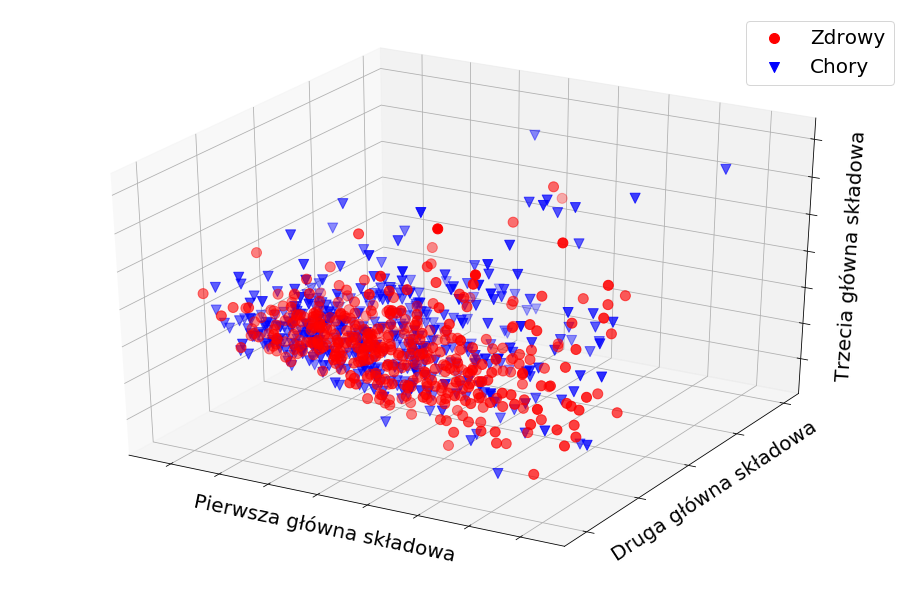

In [8]:
fig = plt.figure()
fig.set_size_inches(16, 10.5)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[X['Status']=='Zdrowy']['A'],
           X[X['Status']=='Zdrowy']['B'],
           X[X['Status']=='Zdrowy']['C'],
           s=100,
           c='r',
           marker='o',
           label='Zdrowy')
ax.scatter(X[X['Status']=='Chory']['A'],
           X[X['Status']=='Chory']['B'],
           X[X['Status']=='Chory']['C'],
           s=100,
           c='b',
           marker='v',
           label='Chory')
plt.legend(loc='upper right', frameon = True, fontsize=20)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
ax.set_xlabel('Pierwsza główna składowa', fontsize=20)
ax.set_ylabel('Druga główna składowa', fontsize=20)
ax.set_zlabel('Trzecia główna składowa', fontsize=20)
plt.show()

# Dummy variables

We'll need to convert categorical features (Status) to dummy variables, because our alghoritm can't understant what means 'healthy'.

In [9]:
status = pd.get_dummies(allpatients['Status'],drop_first=True)

In [10]:
allpatients.drop(['Status'],axis=1,inplace=True)

In [11]:
allpatients['Chory'] = status
allpatients.head()

,MAX,MIN,RMS,KURTOSIS,SKEWNESS,Chory
0,1.102489,-2.150934,0.462709,2.774891,-3.114727,1
1,0.604023,-0.742946,0.873686,0.116155,0.024499,0
2,0.799438,1.054014,-0.983332,2.198539,1.845495,0
3,0.774756,-0.317276,-0.803409,1.401297,-1.078297,0
4,-1.164735,0.590537,-1.044902,-0.468133,-0.609826,0


# Logistic regression algorithm

# Train test split

In [12]:
from sklearn.model_selection import train_test_split

In [103]:
X_train, X_test, y_train, y_test = train_test_split(allpatients.drop(['Chory'],axis=1), 
                                                    allpatients['Chory'], 
                                                    test_size=0.25, 
                                                    random_state=42)

### K-fold validation
I dicided to use k-fold validation due to low num of train examples

In [104]:
num_folds = 5

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# Logistic Regression

In [105]:
from sklearn.linear_model import LogisticRegression

In [132]:
results = {}
best_acc = -1
best_model = None
C = [1e-2, 5e-2, 1e-1, 1.2e-1, 2e-1, 4e-1, 5e-1, 5.25e-1, 5.5e-1, 5.75e-1, 6e-1, 1, 2]

for reg in C:
    #reset accuraties for folds
    train_acc = 0 
    val_acc = 0
    
    for i in range(num_folds):
        logModel = LogisticRegression(penalty='l1', C=reg, solver='liblinear')
        
        train_set = np.concatenate(X_train_folds[:i]+X_train_folds[i+1:])
        labels_set = np.concatenate(y_train_folds[:i]+y_train_folds[i+1:])
        
        logModel.fit(train_set, labels_set)
        #sum acc for each fold
        y_train_pred = logModel.predict(train_set)
        train_acc += np.mean(y_train_pred == labels_set) 
        
        y_val_pred = logModel.predict(X_train_folds[i])
        val_acc += np.mean(y_val_pred == y_train_folds[i])
        
    #compute mean for accuraties
    train_acc /= num_folds
    val_acc /= num_folds
    results[reg] = (train_acc, val_acc)
    if val_acc > best_acc:
            best_acc = val_acc
            best_model = logModel
            
# Print out results.
for C in sorted(results):
    train_accuracy, val_accuracy = results[C]
    print('C %e train accuracy: %f val accuracy: %f' % (
                C, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_acc)

C 1.000000e-02 train accuracy: 0.498452 val accuracy: 0.498595
C 5.000000e-02 train accuracy: 0.584508 val accuracy: 0.574879
C 1.000000e-01 train accuracy: 0.587230 val accuracy: 0.591921
C 1.200000e-01 train accuracy: 0.591510 val accuracy: 0.590371
C 2.000000e-01 train accuracy: 0.594230 val accuracy: 0.590334
C 4.000000e-01 train accuracy: 0.592285 val accuracy: 0.588772
C 5.000000e-01 train accuracy: 0.592675 val accuracy: 0.585659
C 5.250000e-01 train accuracy: 0.594232 val accuracy: 0.588772
C 5.500000e-01 train accuracy: 0.594233 val accuracy: 0.590334
C 5.750000e-01 train accuracy: 0.594232 val accuracy: 0.591897
C 6.000000e-01 train accuracy: 0.596179 val accuracy: 0.591897
C 1.000000e+00 train accuracy: 0.598127 val accuracy: 0.590334
C 2.000000e+00 train accuracy: 0.599295 val accuracy: 0.587221
best validation accuracy achieved during cross-validation: 0.591921


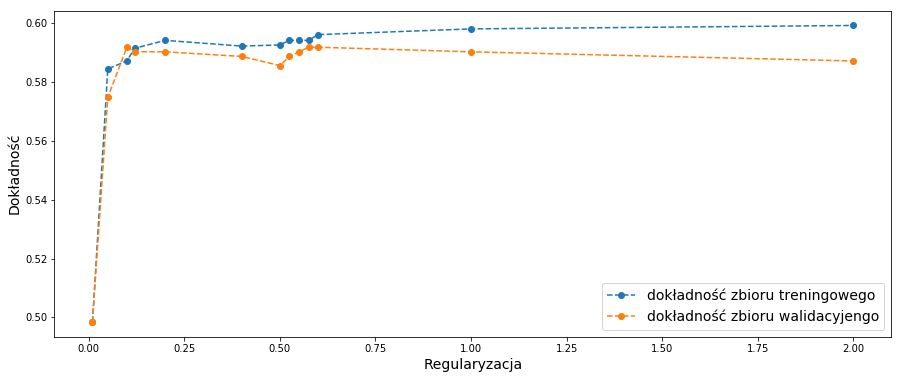

In [133]:
train = []
val = [] 
c = []
for C in sorted(results):
    train_accuracy, val_accuracy = results[C]
    train.append(train_accuracy)
    val.append(val_accuracy)
    c.append(C)
    
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
plt.plot(c,train, 'o--', label='dokładność zbioru treningowego')
plt.plot(c,val, 'o--',label='dokładność zbioru walidacyjengo')
ax.set_xlabel('Regularyzacja', fontsize=14)
ax.set_ylabel('Dokładność', fontsize=14)
plt.legend(loc='lower right', frameon = True, fontsize=14)

In [110]:
prediction = best_model.predict(X_test)

# Evaluation
Check precission, recall, f1-score using classification report

In [111]:
from sklearn.metrics import classification_report, confusion_matrix

In [112]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.59      0.68      0.63       108
           1       0.62      0.53      0.57       106

   micro avg       0.60      0.60      0.60       214
   macro avg       0.60      0.60      0.60       214
weighted avg       0.60      0.60      0.60       214



In [65]:
print(confusion_matrix(y_test,prediction))

[[55 29]
 [45 43]]


# Random Forest

In [113]:
from sklearn.ensemble import RandomForestClassifier

In [141]:
results = {}
best_acc = -1
best_model = None
n_estimators = [10,20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 130 , 140, 150, 200,250, 300]#, 400, 450, 500, 550, 600]

for n in n_estimators:
    #reset accuraties for folds
    val_acc = 0
    
    for i in range(num_folds):
        rf_model = RandomForestClassifier(n_estimators=n)
        
        train_set = np.concatenate(X_train_folds[:i]+X_train_folds[i+1:])
        labels_set = np.concatenate(y_train_folds[:i]+y_train_folds[i+1:])
        
        rf_model.fit(train_set, labels_set) 
        
        y_val_pred = rf_model.predict(X_train_folds[i])
        val_acc += np.mean(y_val_pred == y_train_folds[i])
        
    #compute mean for accuraties
    val_acc /= num_folds
    results[n] = val_acc
    if val_acc > best_acc:
            best_acc = val_acc
            best_model = rf_model

# Print out results.
for n in sorted(results):
    val_accuracy = results[n]
    print('n_estimators %e val accuracy: %f' % (n, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_acc)

n_estimators 1.000000e+01 train accuracy: 0.978584 val accuracy: 0.570155
n_estimators 2.000000e+01 train accuracy: 0.993771 val accuracy: 0.549794
n_estimators 3.000000e+01 train accuracy: 0.998832 val accuracy: 0.596500
n_estimators 4.000000e+01 train accuracy: 0.999611 val accuracy: 0.584084
n_estimators 5.000000e+01 train accuracy: 0.999611 val accuracy: 0.563832
n_estimators 6.000000e+01 train accuracy: 1.000000 val accuracy: 0.568435
n_estimators 7.000000e+01 train accuracy: 1.000000 val accuracy: 0.570058
n_estimators 8.000000e+01 train accuracy: 1.000000 val accuracy: 0.566957
n_estimators 9.000000e+01 train accuracy: 1.000000 val accuracy: 0.584096
n_estimators 1.000000e+02 train accuracy: 1.000000 val accuracy: 0.576332
n_estimators 1.200000e+02 train accuracy: 1.000000 val accuracy: 0.580911
n_estimators 1.300000e+02 train accuracy: 1.000000 val accuracy: 0.568508
n_estimators 1.400000e+02 train accuracy: 1.000000 val accuracy: 0.579433
n_estimators 1.500000e+02 train accura

Text(0,0.5,'dokładność zbioru walidacyjnego')

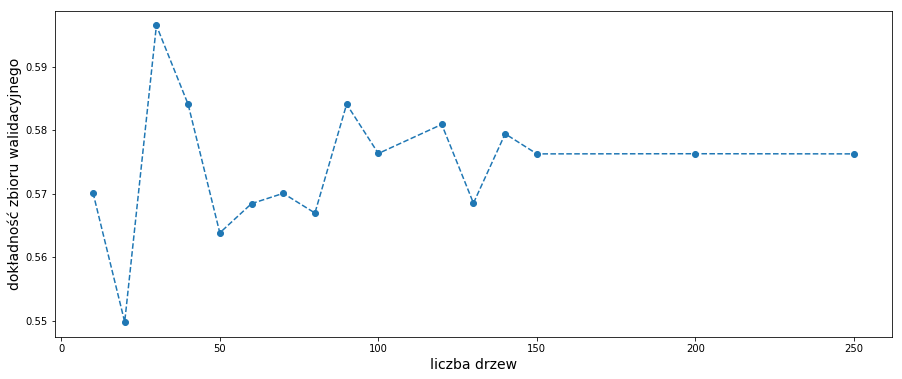

In [144]:
val = [] 
n_estimators = []
for n in sorted(results):
    val_accuracy = results[n]
    val.append(val_accuracy)
    n_estimators.append(n)
    
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
plt.plot(n_estimators[:-1], val[:-1], 'o--')
ax.set_xlabel('liczba drzew', fontsize=14)
ax.set_ylabel('dokładność zbioru walidacyjnego', fontsize=14)

In [145]:
prediction = best_model.predict(X_test)

# Evaluation

In [146]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.59      0.63      0.61       108
           1       0.60      0.56      0.58       106

   micro avg       0.59      0.59      0.59       214
   macro avg       0.59      0.59      0.59       214
weighted avg       0.59      0.59      0.59       214



In [118]:
print(confusion_matrix(y_test, prediction))

[[65 43]
 [42 64]]


In [121]:
feature_importance = best_model.feature_importances_

[Text(0,0,'Maks'),
 Text(0,0,'Min'),
 Text(0,0,'RMS'),
 Text(0,0,'Kurt'),
 Text(0,0,'Skos')]

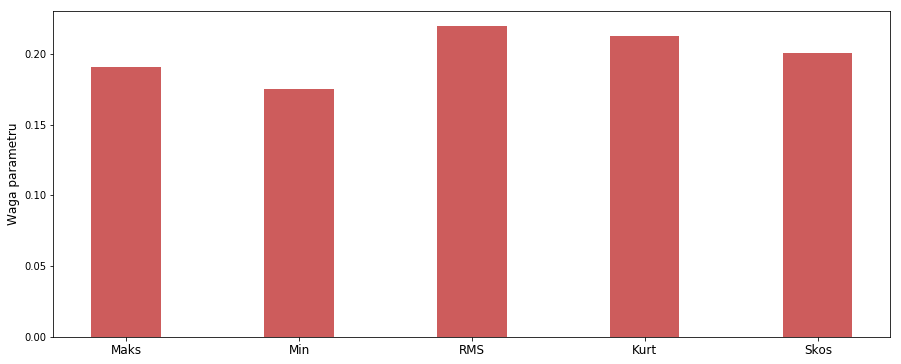

In [122]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
plt.grid(b=False)
ind = np.arange(len(feature_importance))  # the x locations for the groups
width = 0.4  # the width of the bars
ax.bar(ind, feature_importance, width, color='IndianRed')
ax.set_ylabel('Waga parametru', fontsize=12)
ax.set_xticks(ind)
ax.set_xticklabels(['Maks', 'Min', 'RMS', 'Kurt', 'Skos'], fontsize=12)

In [81]:
val_acc

0.5775010734220696